In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from google.colab import files
uploaded = files.upload()


Saving hoax_dataset_with_text.csv to hoax_dataset_with_text.csv


In [4]:
df = pd.read_csv("hoax_dataset_with_text.csv")

In [5]:
df.head()

,judul,link,tanggal,deskripsi,teks
0,[SALAH] Salam 3 Jari dari Anies Bentuk Dukunga...,https://turnbackhoax.id/2024/10/30/salah-salam...,"Oktober 30, 2024","Faktanya, belum ada dukungan resmi Anies untuk...",Terjadi kesalahan: 502
1,[SALAH] Prabowo Ancam Penghujat Pemimpin akan ...,https://turnbackhoax.id/2024/10/30/salah-prabo...,"Oktober 30, 2024",Tidak ada sumber valid yang membenarkan Presid...,Tidak ada sumber valid yang membenarkan Presid...
2,[SALAH] Menkes Budi Sebut Lockdown Pandemi Sel...,https://turnbackhoax.id/2024/10/30/salah-menke...,"Oktober 30, 2024",Tidak ada pernyataan Menkes Budi tentang lockd...,Tidak ada pernyataan Menkes Budi tentang lockd...
3,[SALAH] Prabowo Bilang “Setujukah Rakyat kalau...,https://turnbackhoax.id/2024/10/30/salah-prabo...,"Oktober 30, 2024",Hasil pencarian di Google mengarah ke pemberit...,Hasil pencarian di Google mengarah ke pemberit...
4,[SALAH] Cagub Jakarta Pramono Anung dan Ketua ...,https://turnbackhoax.id/2024/10/30/salah-cagub...,"Oktober 30, 2024",KPK menjelaskan belum ada bukti yang kuat meng...,KPK menjelaskan belum ada bukti yang kuat meng...


In [6]:
print(df.columns)


Index(['judul', 'link', 'tanggal', 'deskripsi', 'teks'], dtype='object')


In [7]:
def extract_label(judul):
    if judul.startswith("[SALAH]"):
        return "hoax"
    else:
        return "valid"

df['label'] = df['judul'].apply(extract_label)


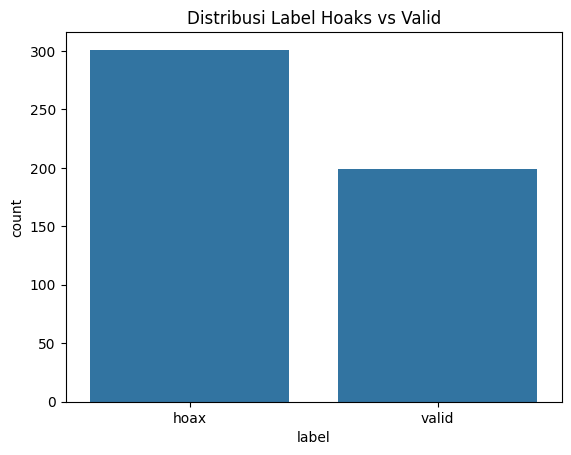

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='label')
plt.title("Distribusi Label Hoaks vs Valid")
plt.show()


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   judul      500 non-null    object
 1   link       500 non-null    object
 2   tanggal    500 non-null    object
 3   deskripsi  500 non-null    object
 4   teks       500 non-null    object
 5   label      500 non-null    object
dtypes: object(6)
memory usage: 23.6+ KB


In [10]:
print(df.columns)


Index(['judul', 'link', 'tanggal', 'deskripsi', 'teks', 'label'], dtype='object')


STEP TOKENISASI IndoBERT + PROCESSING

In [11]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

In [12]:
df['teks'] = df['teks'].astype(str)

tokenized = tokenizer(
    list(df['teks']),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='pt'
)


In [13]:
df['teks'] = df['teks'].astype(str)

In [14]:
tokenized = tokenizer(
    list(df['teks']),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

STEP LABEL ENCODING + TRAIN-TEST SPLIT

In [15]:
from sklearn.model_selection import train_test_split
import torch

In [16]:
df['label'] = df['label'].map({'hoax': 1, 'valid': 0})

In [17]:
input_ids = tokenized['input_ids']
attention_mask = tokenized['attention_mask']
labels = torch.tensor(df['label'].values)

In [18]:
X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids,
    attention_mask,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

penjelasan

input_ids = hasil konversi kata ke token angka dari IndoBERT.

attention_mask = penanda token mana yang valid dan mana yang padding (0).

y_train dan y_test = label target untuk training dan evaluasi.

**STEP DEFINISI MODEL IndoBERT + CNN-LSTM**

In [19]:
import torch
import torch.nn as nn
from transformers import BertModel

In [20]:
class IndoBERT_CNN_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('indobenchmark/indobert-base-p1')
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = x.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(x)
        logits = self.fc(h_n.squeeze(0))
        return logits


STEP TRAINING LOOP + EVALUASI

In [21]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
train_dataset = TensorDataset(X_train_ids, X_train_mask, y_train)
test_dataset = TensorDataset(X_test_ids, X_test_mask, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IndoBERT_CNN_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

for epoch in range(2):  # Bisa tambah epoch kalau GPU cukup kuat
    model.train()
    total_loss = 0

for batch in train_loader:
    input_ids, attention_mask, labels = [b.to(device) for b in batch]

    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss/len(train_loader):.4f}")

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Epoch 2 - Loss: 0.0273
Epoch 2 - Loss: 0.0555
Epoch 2 - Loss: 0.0830
Epoch 2 - Loss: 0.1099
Epoch 2 - Loss: 0.1381
Epoch 2 - Loss: 0.1666
Epoch 2 - Loss: 0.1933
Epoch 2 - Loss: 0.2199
Epoch 2 - Loss: 0.2467
Epoch 2 - Loss: 0.2743
Epoch 2 - Loss: 0.3006
Epoch 2 - Loss: 0.3276
Epoch 2 - Loss: 0.3537
Epoch 2 - Loss: 0.3788
Epoch 2 - Loss: 0.4040
Epoch 2 - Loss: 0.4299
Epoch 2 - Loss: 0.4544
Epoch 2 - Loss: 0.4811
Epoch 2 - Loss: 0.5086
Epoch 2 - Loss: 0.5354
Epoch 2 - Loss: 0.5631
Epoch 2 - Loss: 0.5881
Epoch 2 - Loss: 0.6129
Epoch 2 - Loss: 0.6368
Epoch 2 - Loss: 0.6599


STEP EVALUASI MODEL

In [22]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["valid", "hoax"]))

print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))

Classification Report:

              precision    recall  f1-score   support

       valid       1.00      0.15      0.26        40
        hoax       0.64      1.00      0.78        60

    accuracy                           0.66       100
   macro avg       0.82      0.57      0.52       100
weighted avg       0.78      0.66      0.57       100

Confusion Matrix:

[[ 6 34]
 [ 0 60]]


In [23]:
from google.colab import files
uploaded = files.upload()

Saving kompas_dataset_with_text.csv to kompas_dataset_with_text.csv


In [24]:
df_valid = pd.read_csv("kompas_dataset_with_text.csv")

In [25]:
df_hoax = df

In [26]:
df_valid['label'] = 'valid'
df_hoax['label'] = 'hoax'

In [27]:
df_valid = df_valid[['teks', 'label']].dropna()
df_hoax = df_hoax[['teks', 'label']].dropna()

In [28]:
df_final = pd.concat([df_valid, df_hoax]).sample(frac=1, random_state=42).reset_index(drop=True)

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt


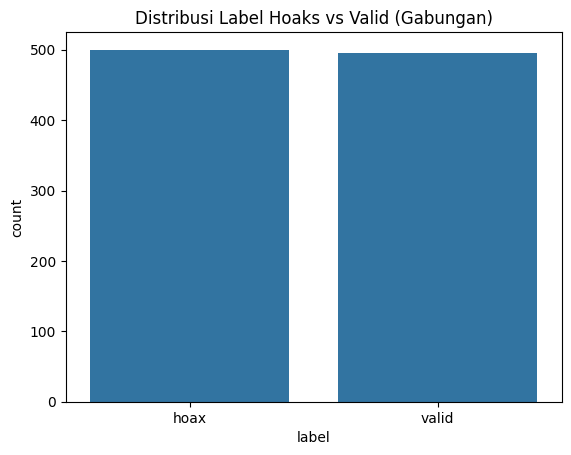

In [30]:
sns.countplot(data=df_final, x='label')
plt.title("Distribusi Label Hoaks vs Valid (Gabungan)")
plt.show()

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_final['label_enc'] = le.fit_transform(df_final['label'])
X_train, X_test, y_train, y_test = train_test_split(
    df_final['teks'], df_final['label_enc'],
    test_size=0.2, random_state=42, stratify=df_final['label_enc']
)

In [32]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
def tokenize_batch(texts):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

train_encodings = tokenize_batch(X_train)
test_encodings = tokenize_batch(X_test)
import torch
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)
X_train_ids = train_encodings['input_ids']
X_train_mask = train_encodings['attention_mask']
X_test_ids = test_encodings['input_ids']
X_test_mask = test_encodings['attention_mask']

In [33]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train_ids, X_train_mask, y_train)
test_dataset = TensorDataset(X_test_ids, X_test_mask, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [34]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = IndoBERT_CNN_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [35]:
for epoch in range(2):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

Epoch 1 - Loss: 0.5714
Epoch 2 - Loss: 0.3282


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["valid", "hoax"]))

print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))

Classification Report:

              precision    recall  f1-score   support

       valid       0.97      0.96      0.96       100
        hoax       0.96      0.97      0.96        99

    accuracy                           0.96       199
   macro avg       0.96      0.96      0.96       199
weighted avg       0.96      0.96      0.96       199

Confusion Matrix:

[[96  4]
 [ 3 96]]


imbang, recall tinggi di hoaks 98% artinya model deteksinya baik dan precisionnya tinggi artinya berita hoaks nya bener" hoaks. dari condusion matrix artinya ada 199 data dan yg 193 data terprediksi benar sedangkan 6 data salah

**Analisis Statistik**

In [37]:
df_final['panjang_karakter'] = df_final['teks'].apply(len)
df_final['jumlah_kata'] = df_final['teks'].apply(lambda x: len(str(x).split()))
print(df_final[['panjang_karakter', 'jumlah_kata']].describe())

       panjang_karakter  jumlah_kata
count        995.000000   995.000000
mean        2225.472362   272.377889
std          643.997636    87.938816
min           22.000000     3.000000
25%         1761.000000   206.000000
50%         2157.000000   265.000000
75%         2609.500000   332.000000
max         5154.000000   666.000000


**Visualisasi Pendukung**

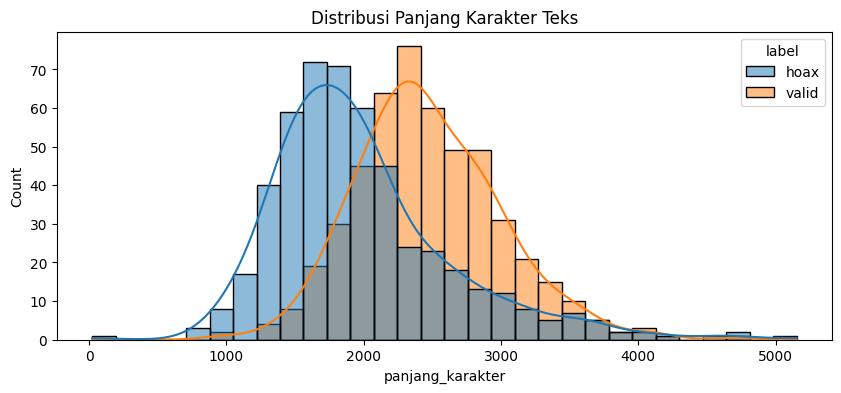

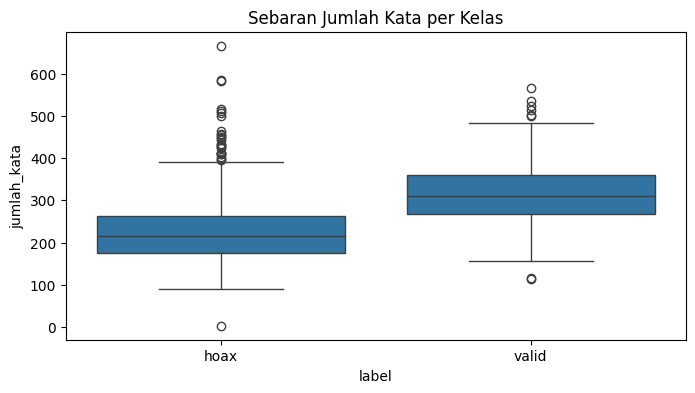

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
sns.histplot(data=df_final, x='panjang_karakter', hue='label', kde=True, bins=30)
plt.title("Distribusi Panjang Karakter Teks")
plt.show()
plt.figure(figsize=(8,4))
sns.boxplot(data=df_final, x='label', y='jumlah_kata')
plt.title("Sebaran Jumlah Kata per Kelas")
plt.show()

In [39]:
df_hoax['label'] = 'hoax'
df_valid['label'] = 'valid'

df_hoax = df_hoax[['teks', 'label']]
df_valid = df_valid[['teks', 'label']]
df = pd.concat([df_hoax, df_valid]).sample(frac=1, random_state=42).reset_index(drop=True)
df['label_enc'] = df['label'].map({'valid': 0, 'hoax': 1})

CLEANING TEXT


In [40]:
import re

def clean_text(text):
    text = str(text).lower()  # lowercase
    text = re.sub(r"http\S+|www.\S+", '', text)  # hapus URL
    text = re.sub(r"\d+", '', text)  # hapus angka
    text = re.sub(r"[^\w\s]", '', text)  # hapus tanda baca
    text = re.sub(r"\s+", ' ', text).strip()  # hapus spasi ganda
    return text

# Terapkan ke kolom teks
df['teks_clean'] = df['teks'].apply(clean_text)

# Cek hasil
df[['teks', 'teks_clean']].head()


,teks,teks_clean
0,"JAKARTA, KOMPAS.com- Ketua Badan Pengawas Pemi...",jakarta kompascom ketua badan pengawas pemilu ...
1,"JAKARTA, KOMPAS.com- Menteri Agraria dan Tata ...",jakarta kompascom menteri agraria dan tata rua...
2,"JAKARTA, KOMPAS.com- Kepala Staf Kepresidenan ...",jakarta kompascom kepala staf kepresidenan ksp...
3,"TANGERANG, KOMPAS.com- Polisi mendalami kasusp...",tangerang kompascom polisi mendalami kasuspeny...
4,"JAKARTA, KOMPAS.com- Presiden Human Initiative...",jakarta kompascom presiden human initiative to...


In [41]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

# Contoh pakai TF-IDF buat vektor teks
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['teks_clean'])
y = df['label_enc']

# Oversampling dengan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Cek distribusi baru
from collections import Counter
print(Counter(y_resampled))


Counter({0: 500, 1: 500})


In [42]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   teks        995 non-null    object
 1   label       995 non-null    object
 2   label_enc   995 non-null    int64 
 3   teks_clean  995 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.2+ KB


,0
teks,0
label,0
label_enc,0
teks_clean,0


In [43]:
df['label'].value_counts()
df['label'].value_counts(normalize=True) * 100

,proportion
label,
hoax,50.251256
valid,49.748744


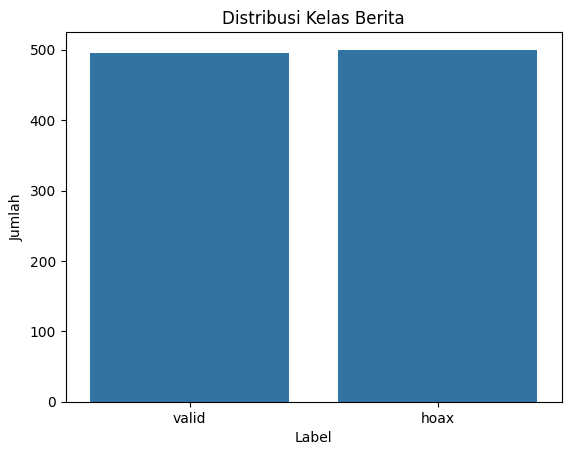

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='label')
plt.title("Distribusi Kelas Berita")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.show()

In [45]:
df['panjang_karakter'] = df['teks'].apply(len)
df['jumlah_kata'] = df['teks'].apply(lambda x: len(str(x).split()))
df[['panjang_karakter', 'jumlah_kata']].describe()

,panjang_karakter,jumlah_kata
count,995.000000,995.000000
mean,2225.472362,272.377889
std,643.997636,87.938816
min,22.000000,3.000000
25%,1761.000000,206.000000
50%,2157.000000,265.000000
75%,2609.500000,332.000000
max,5154.000000,666.000000


In [46]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

# Tokenisasi teks
tokenized = tokenizer(
    list(df['teks']),
    padding='max_length',
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

In [47]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])  # hoax → 1, valid → 0

In [48]:
class IndoBERT_CNN_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('indobenchmark/indobert-base-p1')
        self.conv1 = nn.Conv1d(768, 128, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(128, 64, batch_first=True)
        self.fc = nn.Linear(64, 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # IndoBERT digunakan sebagai feature extractor
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state
        x = x.permute(0, 2, 1)  # CNN butuh format (batch, channels, seq)
        x = self.conv1(x)
        x = x.permute(0, 2, 1)  # LSTM butuh (batch, seq, channels)
        _, (h_n, _) = self.lstm(x)
        logits = self.fc(h_n.squeeze(0))
        return logits

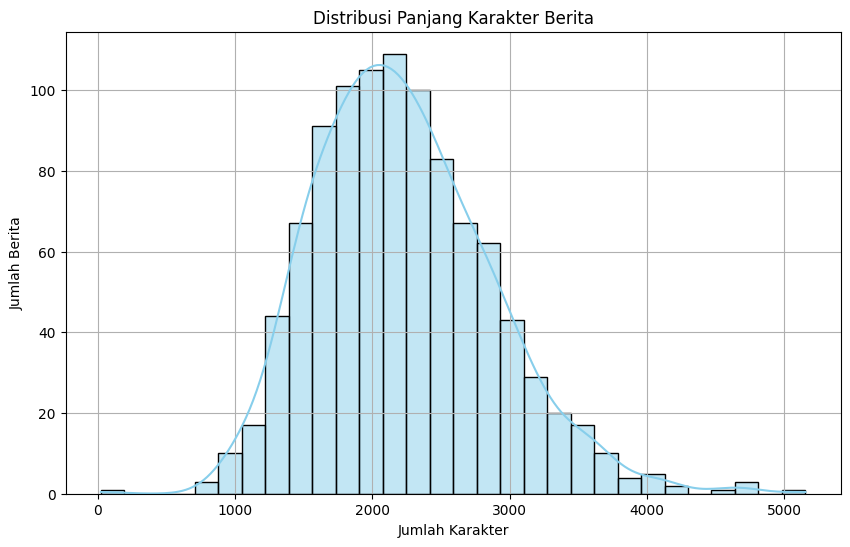

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['panjang_karakter'], bins=30, kde=True, color='skyblue')
plt.title("Distribusi Panjang Karakter Berita")
plt.xlabel("Jumlah Karakter")
plt.ylabel("Jumlah Berita")
plt.grid(True)
plt.show()


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

# TF-IDF vektorisasi teks
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['teks_clean'])  # gunakan teks hasil cleaning
y = df['label_enc']

# Oversampling dengan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

print("Distribusi label setelah SMOTE:", Counter(y_resampled))

# atau bisa coba ADASYN:
# adasyn = ADASYN(random_state=42)
# X_resampled, y_resampled = adasyn.fit_resample(X_tfidf, y)


Distribusi label setelah SMOTE: Counter({1: 500, 0: 500})


In [51]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

# Tokenisasi teks
tokenized = tokenizer(
    list(df['teks']),
    padding='max_length',
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

# Hasil embedding dalam bentuk input_ids dan attention_mask
X_train_ids = train_encodings['input_ids']
X_train_mask = train_encodings['attention_mask']
X_test_ids = test_encodings['input_ids']
X_test_mask = test_encodings['attention_mask']